<a href="https://colab.research.google.com/github/TongVietHoang-1611/SNNTorch/blob/main/SNNTorch_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a tutorial from SNNTorch Documents
#### By Jason K. Eshraghian (www.ncg.ucsc.edu)
#####Link:https://snntorch.readthedocs.io/en/latest/index.html



###**TUTORIAL 1**



In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 5.0 MB/s eta 0:00:00


In [ ]:
import snntorch as snn
import torch

In [ ]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

In [ ]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

In [ ]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

###***Rate coding of MNIST***


One example of converting input data into a rate code is as follows. Each normalised input feature  Xij  is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value  Rij . This can be treated as a Bernoulli trial:  Rij∼B(n,p) , where the number of trials is  n=1 , and the probability of success (spiking) is  p=Xij . Explicitly, the probability a spike occurs is:

P(Rij=1)=Xij=1−P(Rij=0)

In [ ]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 49.00% of the time.


In a similar way, **spikegen.rate** can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use num_steps to repeat it across time.

In [ ]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

100 là số lượng bước, 128 là số lượng batch ( batch size) và 1 28 28 là kích thước ảnh


In [ ]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

**snnTorch** contains a module snntorch.spikeplot that simplifies the process of visualizing, plotting, and animating spiking neurons.
To plot one sample of data, index into a single sample from the batch (B) dimension of spike_data, [T x B x 1 x 28 x 28]
spikeplot.animator makes it super simple to animate 2-D data.



In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


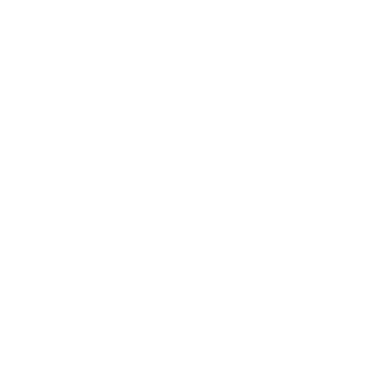

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
HTML(anim.to_html5_video())

In [ ]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 6


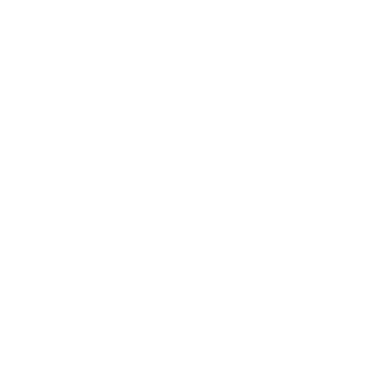

In [ ]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

The case where gain=0.25 is lighter than where gain=1, as spiking probability has been reduced by a factor of  ×4 .

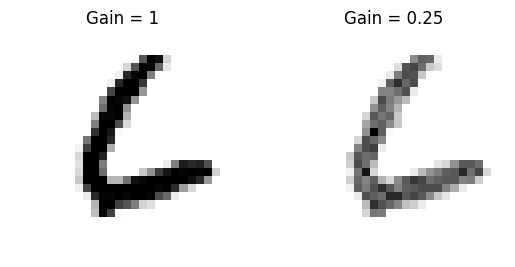

In [ ]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The following code snippet shows how to index into one single neuron.
Depending on the input data, you may need to try
a few different neurons between **0 &** **784** before finding one that
spikes.

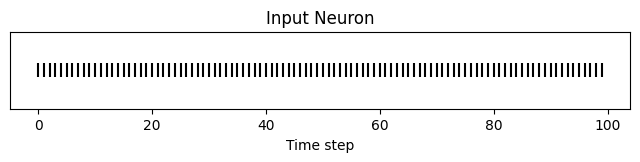

In [ ]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

###**Summary of Rate Coding**
The idea of rate coding is actually quite controversial. Although we are fairly confident rate coding takes place at our sensory periphery, we are not convinced that the cortex globally encodes information as spike rates. A couple of compelling reasons why include:

*   **Power Consumption:** Nature optimised for efficiency. Multiple spikes are needed to achieve any sort of task, and each spike consumes power. In fact, [Olshausen and Field's work in "What is the other 85% of V1 doing?"](http://www.rctn.org/bruno/papers/V1-chapter.pdf) demonstrates that rate-coding can only explain, at most, the activity of 15% of neurons in the primary visual cortex (V1). It is unlikely to be the only mechanism within the brain, which is both resource-constrained and highly efficient.


*   **Reaction Response Times:** We know that the reaction time of a human is roughly around 250ms. If the average firing rate of a neuron in the human brain is on the order of 10Hz, then we can only process about 2 spikes within our reaction timescale.

So why, then, might we use rate codes if they are not optimal for power efficiency or latency? Even if our brain doesn't process data as a rate, we are fairly sure that our biological sensors do. The power/latency disadvantages are partially offset by showing huge noise robustness: it's fine if some of the spikes fail to generate, because there will be plenty more where they came from.

Additionally, you may have heard of the [Hebbian mantra of "neurons that fire together, wire together"](https://doi.org/10.2307/1418888). If there is plenty of spiking, this may suggest there is plenty of learning. In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution.

Rate coding is almost certainly working in conjunction with other encoding schemes in the brain. We will consider these other encoding mechanisms in the following sections.
This covers the `spikegen.rate` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).


###  Latency Coding of MNIST

Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

The following block derives how this works. If you've forgotten circuit theory and/or the math means nothing to you, then don't worry! All that matters is: **big** input means **fast** spike; **small** input means **late** spike.

---
**Optional: Derivation of Latency Code Mechanism**

By default, spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit. This current moves charge onto the capacitor, which increases $V(t)$. We assume that there is a trigger voltage, $V_{thr}$, which once reached, generates a spike. The question then becomes: *for a given input current (and equivalently, input feature), how long does it take for a spike to be generated?*

Starting with Kirchhoff's current law, $I_{in} = I_R + I_C$, the rest of the derivation leads us to a logarithmic relationship between time and the input.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

In [ ]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

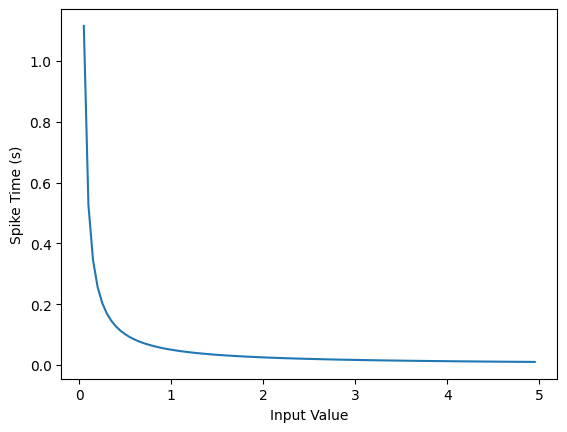

In [ ]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

The smaller the value, the later the spike occurs with exponential dependence.

The vector `spike_times` contains the time at which spikes are triggered, rather than a sparse tensor that contains the spikes themselves (1's and 0's).
When running an SNN simulation, we need the 1/0 representation to obtain all of the advantages of using spikes.
This whole process can be automated using `spikegen.latency`, where we pass a minibatch from the MNIST dataset in `data_it`:

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

Some of the arguments include:

* `tau`:  the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.

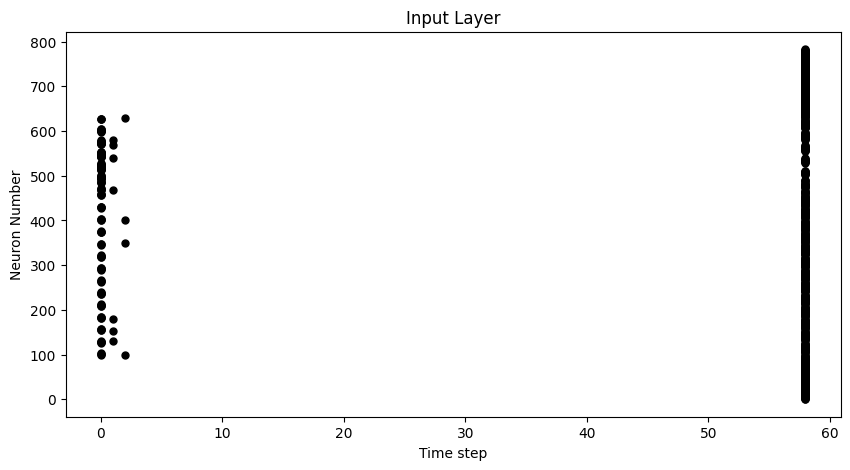

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

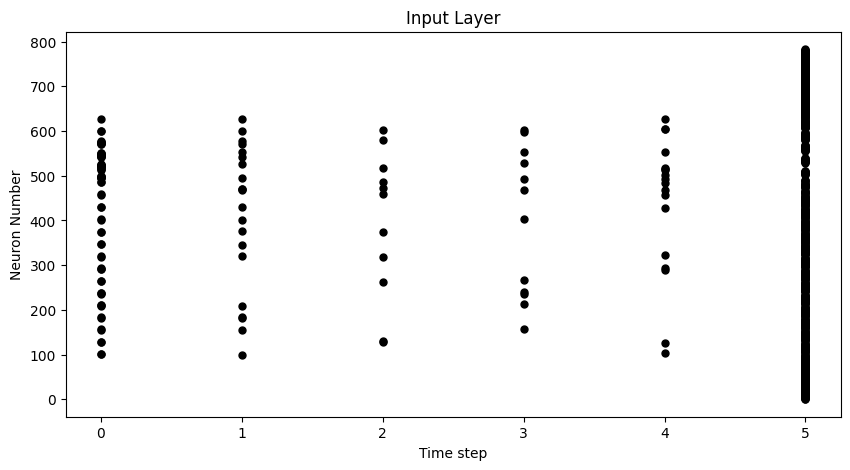

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)
#spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The spread of firing times is much more evenly distributed now. This is achieved by linearizing the logarithmic equation according to the rules shown below. Unlike the RC model, there is no physical basis for the model. It's just simpler.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


But note how all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps.
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting the optional argument `normalize=True` to span the full range of `num_steps`.

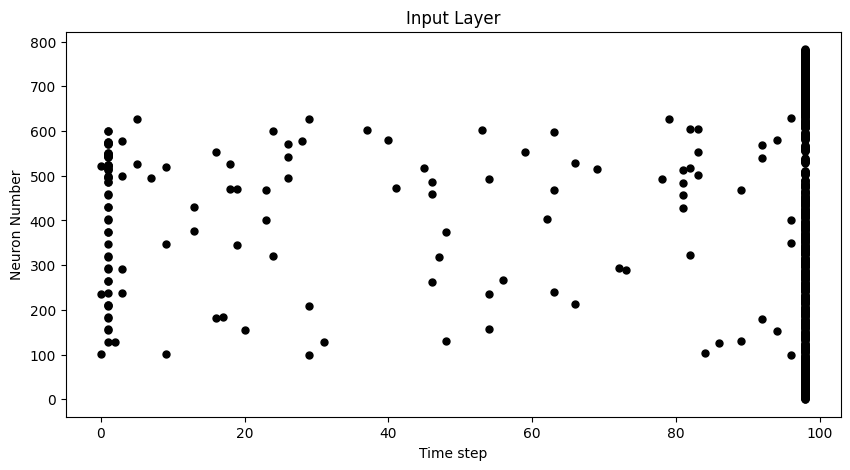

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by setting `clip=True`.

###**Removed  redundant features by setting clip=True.**

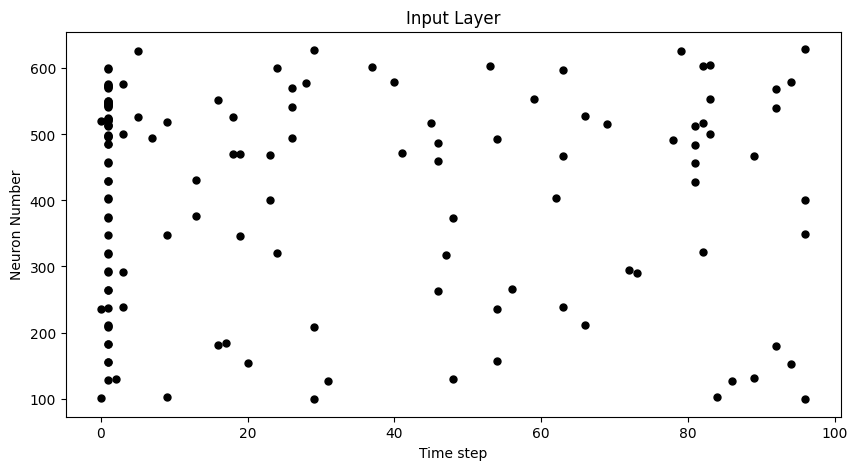

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

torch.Size([100, 28, 28])


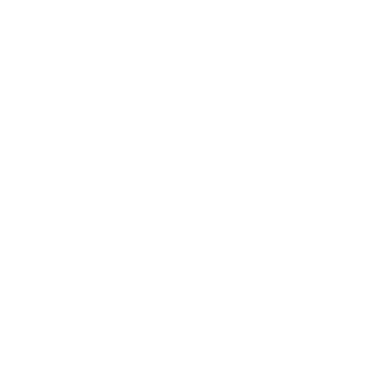

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

###  Delta Modulation
There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are  less prone to firing.

That is to say: **biology is event-driven**. Neurons thrive on change.

As a nifty example, a few researchers have dedicated their lives to designing retina-inspired image sensors, for example, the [Dynamic Vision Sensor](https://ieeexplore.ieee.org/abstract/document/7128412/). Although [the attached link is from over a decade ago, the work in this video](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) was ahead of its time.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

To illustrate, let's first come up with a contrived example where we create our own input tensor.

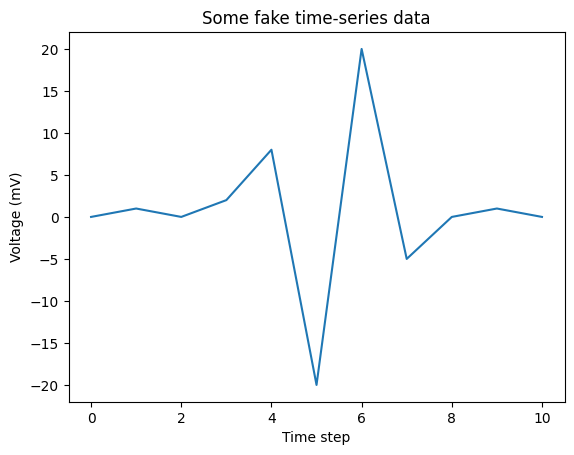

In [ ]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

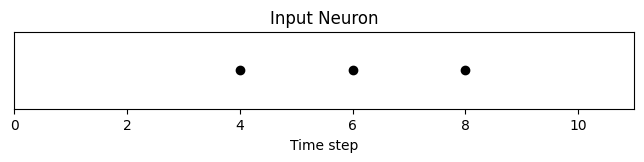

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*.

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

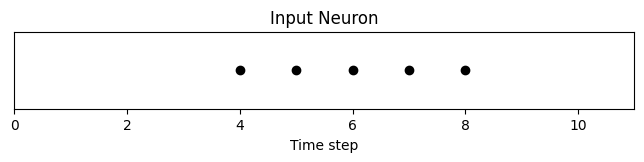

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

In [ ]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


# snnTorch - The Leaky Integrate and Fire Neuron
## Tutorial 2

In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

### The Spectrum of Neuron Models
A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the extremely simple artificial neuron that pervades all facets of modern deep learning.

**Hodgkin-Huxley Neuron Models**$-$While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use at present.

**Artificial Neuron Model**$-$On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights and passed through an activation function. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks.

**Leaky Integrate-and-Fire Neuron Models**$-$Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike. The LIF neuron abstracts away the shape and profile of the output spike; it is simply treated as a discrete event. As a result, information is not stored within the spike, but rather the timing (or frequency) of spikes. Simple spiking neuron models have produced much insight into the neural code, memory, network dynamics, and more recently, deep learning. The LIF neuron sits in the sweet spot between biological plausibility and practicality.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>


The different versions of the LIF model each have their own dynamics and use-cases. snnTorch currently supports the following LIF neurons:
* Lapicque's RC model: ``snntorch.Lapicque``
* 1st-order model: ``snntorch.Leaky``
* Synaptic Conductance-based neuron model: ``snntorch.Synaptic``
* Recurrent 1st-order model: ``snntorch.RLeaky``
* Recurrent Synaptic Conductance-based neuron model: ``snntorch.RSynaptic``
* Alpha neuron Model: ``snntorch.Alpha``

Several other non-LIF spiking neurons are also available. This tutorial focuses on the first of these models. This will be used to build towards the other models in [subsequent tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

#  The Leaky Integrate-and-Fire Neuron Model

##  Spiking Neurons: Intuition

In our brains, a neuron might be connected to 1,000 $-$ 10,000 other neurons. If one neuron spikes, all downhill neurons might feel it. But what determines whether a neuron spikes in the first place? The past century of experiments demonstrate that if a neuron experiences *sufficient* stimulus at its input, then it might become excited and fire its own spike.

Where does this stimulus come from? It could be from:
* the sensory periphery,
* an invasive electrode artificially stimulating the neuron, or in most cases,
* from other pre-synaptic neurons.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>

Given that these spikes are very short bursts of electrical activity, it is quite unlikely for all input spikes to arrive at the neuron body in precise unison. This indicates the presence of temporal dynamics that 'sustain' the input spikes, kind of like a delay.



##  The Passive Membrane

Like all cells, a neuron is surrounded by a thin membrane. This membrane is a lipid bilayer that insulates the conductive saline solution within the neuron from the extracellular medium. Electrically, the two conductive solutions separated by an insulator act as a capacitor.

Another function of this membrane is to control what goes in and out of this cell (e.g., ions such as Na$^+$). The membrane is usually impermeable to ions which blocks them from entering and exiting the neuron body. But there are specific channels in the membrane that are triggered to open by injecting current into the neuron. This charge movement is electrically modelled by a resistor.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>

The following block will derive the behaviour of a LIF neuron from scratch. If you'd prefer to skip the math, then feel free to scroll on by; we'll take a more hands-on approach to understanding the LIF neuron dynamics after the derivation.


---
**Optional: Derivation of LIF Neuron Model**

Now say some arbitrary time-varying current $I_{\rm in}(t)$ is injected into the neuron, be it via electrical stimulation or from other neurons. The total current in the circuit is conserved, so:

$$I_{\rm in}(t) = I_{R} + I_{C}$$

From Ohm's Law, the membrane potential measured between the inside and outside of the neuron $U_{\rm mem}$ is proportional to the current through the resistor:

$$I_{R}(t) = \frac{U_{\rm mem}(t)}{R}$$

The capacitance is a proportionality constant between the charge stored on the capacitor $Q$ and $U_{\rm mem}(t)$:


$$Q = CU_{\rm mem}(t)$$

The rate of change of charge gives the capacitive current:

$$\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}$$

Therefore:

$$I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}$$

$$\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The right hand side of the equation is of units **\[Voltage]**. On the left hand side of the equation, the term $\frac{dU_{\rm mem}(t)}{dt}$ is of units **\[Voltage/Time]**. To equate it to the left hand side (i.e., voltage), $RC$ must be of unit **\[Time]**. We refer to $\tau = RC$ as the time constant of the circuit:

$$ \tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The passive membrane is therefore described by a linear differential equation.

For a derivative of a function to be of the same form as the original function, i.e., $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$, this implies the solution is exponential with a time constant $\tau$.

Say the neuron starts at some value $U_{0}$ with no further input, i.e., $I_{\rm in}(t)=0$. The solution of the linear differential equation is:

$$U_{\rm mem}(t) = U_0e^{-\frac{t}{\tau}}$$

The general solution is shown below.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

---

In [ ]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

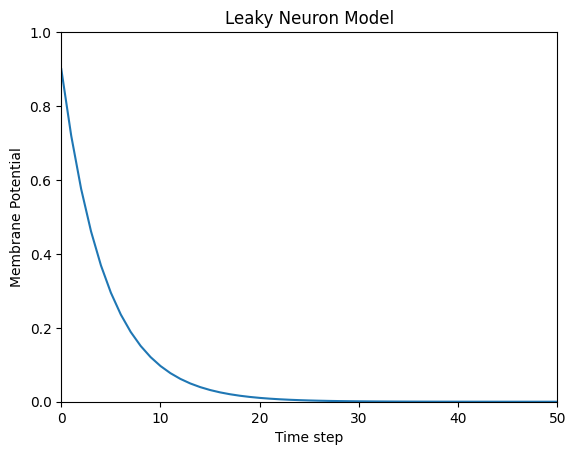

In [ ]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")




# snnTorch - A Feedforward Spiking Neural Network
## Tutorial 3
In this tutorial, you will:
* Learn how to simplify the leaky integrate-and-fire (LIF) neuron to make it deep learning-friendly
* Implement a feedforward spiking neural network (SNN)

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.





In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Simplifying the Leaky Integrate-and-Fire Neuron Model
In the previous tutorial, we designed our own LIF neuron model. But it was quite complex, and added an array of hyperparameters to tune, including $R$, $C$, $\Delta t$, $U_{\rm thr}$, and the choice of reset mechanism. This is a lot to keep track of, and only grows more cumbersome when scaled up to a full-blown SNN. So let's make a few simplfications.


## 1.1 The Decay Rate: $\beta$

In the previous tutorial, the Euler method was used to derive the following solution to the passive membrane model:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) + \frac{\Delta t}{\tau} I_{\rm in}(t)R \tag{1}$$

Now assume there is no input current, $I_{\rm in}(t)=0 A$:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) \tag{2}$$

Let the ratio of subsequent values of $U$, i.e., $U(t+\Delta t)/U(t)$ be the decay rate of the membrane potential, also known as the inverse time constant:

$$U(t+\Delta t) = \beta U(t) \tag{3}$$

From $(1)$, this implies that:

$$\beta = (1-\frac{\Delta t}{\tau}) \tag{4}$$

For reasonable accuracy, $\Delta t << \tau$.

## 1.2 Weighted Input Current
If we assume $t$ represents time-steps in a sequence rather than continuous time, then we can set $\Delta t = 1$. To further reduce the number of hyperparameters, assume $R=1$. From $(4)$, these assumptions lead to:

$$\beta = (1-\frac{1}{C}) \implies (1-\beta)I_{\rm in} = \frac{1}{\tau}I_{\rm in} \tag{5}$$

The input current is weighted by $(1-\beta)$.
By additionally assuming input current instantaneously contributes to the membrane potential:

$$U[t+1] = \beta U[t] + (1-\beta)I_{\rm in}[t+1] \tag{6}$$

Note that the discretization of time means we are assuming that each time bin $t$ is brief enough such that a neuron may only emit a maximum of one spike in this interval.

In deep learning, the weighting factor of an input is often a learnable parameter. Taking a step away from the physically viable assumptions made thus far, we subsume the effect of $(1-\beta)$ from $(6)$ into a learnable weight $W$, and replace $I_{\rm in}[t]$ accordingly with an input $X[t]$:

$$WX[t] = I_{\rm in}[t] \tag{7}$$

This can be interpreted in the following way. $X[t]$ is an input voltage, or spike, and is scaled by the synaptic conductance of $W$ to generate a current injection to the neuron. This gives us the following result:

$$U[t+1] = \beta U[t] + WX[t+1] \tag{8}$$


In future simulations, the effects of $W$ and $\beta$ are decoupled.
$W$ is a learnable parameter that is updated independently of $\beta$.


## 1.3 Spiking and Reset
We now introduce the spiking and reset mechanisms. Recall that if the membrane exceeds the threshold, then the neuron emits an output spike:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{9}$$

If a spike is triggered, the membrane potential should be reset. The *reset-by-subtraction* mechanism is modeled by:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{10}$$

As $W$ is a learnable parameter, and $U_{\rm thr}$ is often just set to $1$ (though can be tuned), this leaves the decay rate $\beta$ as the only hyperparameter left to be specified. This completes the painful part of this tutorial.

> Note: some implementations might make slightly different assumptions. E.g., $S[t] \rightarrow S[t+1]$ in $(9)$, or $X[t] \rightarrow X[t+1]$ in $(10)$. This above derivation is what is used in snnTorch as we find it maps intuitively to a recurrent neural network representation, without any change in performance.

In [ ]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

To set $\beta$, we have the option of either using Equation $(3)$ to define it, or hard-coding it directly. Here, we will use $(3)$ for the sake of a demonstration, but in future, it will just be hard-coded as we are more focused on something that works rather than biological precision.

Equation $(3)$ tells us that $\beta$ is the ratio of membrane potential across two subsequent time steps. Solve this using the continuous time-dependent form of the equation (assuming no current injection), which was derived in [Tutorial 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html):

$$U(t) = U_0e^{-\frac{t}{\tau}}$$

$U_0$ is the initial membrane potential at $t=0$. Assume the time-dependent equation is computed at discrete steps of $t, (t+\Delta t), (t+2\Delta t)~...~$, then we can find the ratio of membrane potential between subsequent steps using:

$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [ ]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


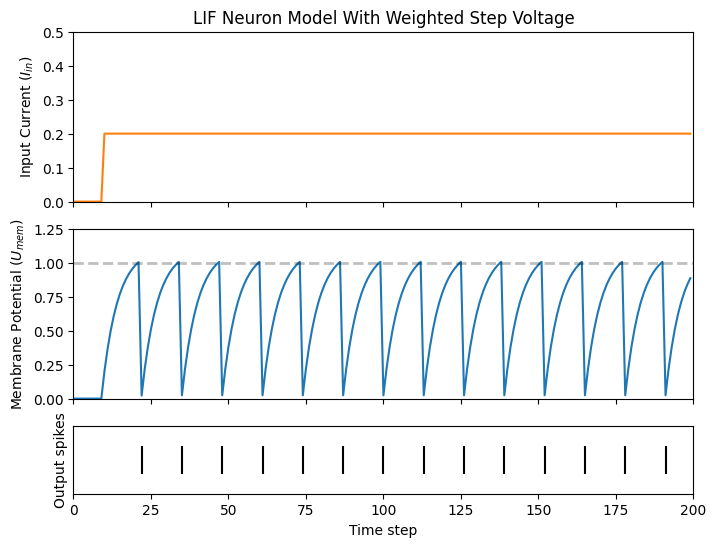

In [ ]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

An almost identical neuron can be achieved by instantiating `snn.Leaky`, in a similar way to how we used `snn.Lapicque` in the previous tutorial. But with less hyperparameters:



In [ ]:
lif1 = snn.Leaky(beta=0.8)

The neuron model is now stored in `lif1`. To use this neuron:

**Inputs**
* `cur_in`: each element of $W\times X[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step

These all need to be of type `torch.Tensor`. Note that here, we assume the input current has already been weighted before passing into the `snn.Leaky` neuron. This will make more sense when we construct a network-scale model. Also, equation $(10)$ has been time-shifted back one step without loss of generality.


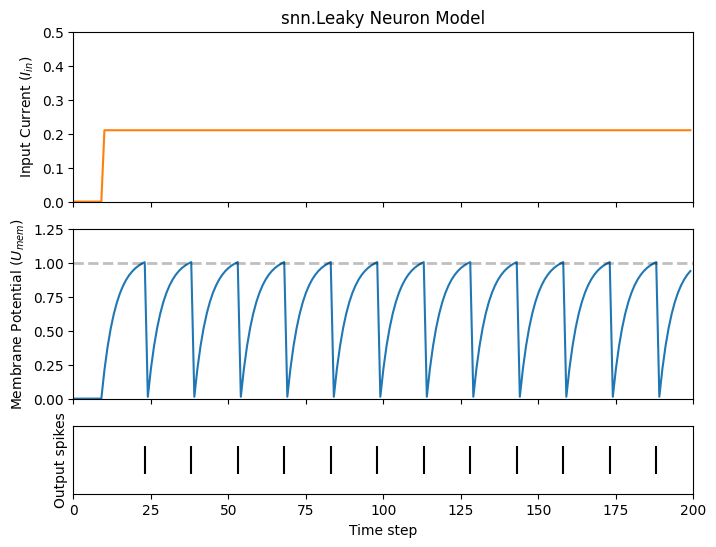

In [ ]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

Compare this plot with the manually derived leaky integrate-and-fire neuron. The membrane potential reset is slightly weaker: i.e., it uses a *soft reset*. This has been done intentionally because it enables better performance on a few deep learning benchmarks. The equation used instead is:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{\beta S[t]U_{\rm thr}}_\text{soft reset} \tag{11}$$


This model has the same optional input arguments of `reset_mechanism` and `threshold` as described for Lapicque's neuron model.

# 3. A Feedforward Spiking Neural Network

So far, we have only considered how a single neuron responds to input stimulus. snnTorch makes it straightforward to scale this up to a deep neural network. In this section, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch is used to form the connections between neurons, and snnTorch to create the neurons. First, initialize all layers.

In [ ]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

Next, initialize the hidden variables and outputs of each spiking neuron.
As networks increase in size, this becomes more tedious. The static method `init_leaky()` can be used to take care of this. All neurons in snnTorch have their own initialization methods that follow this same syntax, e.g., `init_lapicque()`. The shape of the hidden states are automatically initialized based on the input data dimensions during the first forward pass.

In [ ]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of $200 \times 784$. However, neural nets typically process data in minibatches. snnTorch uses time-first dimensionality:

[$time \times batch\_size \times feature\_dimensions$]

So 'unsqueeze' the input along `dim=1` to indicate 'one batch' of data. The dimensions of this input tensor must be 200 $\times$ 1 $\times$ 784:

In [ ]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


Now it's finally time to run a full simulation.
An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Here is a sequential account of what's going on:

*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_{i} \times W_{ij}$
* This generates the input current term from Equation $(10)$, contributing to $U[t+1]$ of the spiking neuron
* If $U[t+1] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.

The only difference from our simulations thus far is that we are now scaling the input current with a weight generated by `nn.Linear`, rather than manually setting $W$ ourselves.

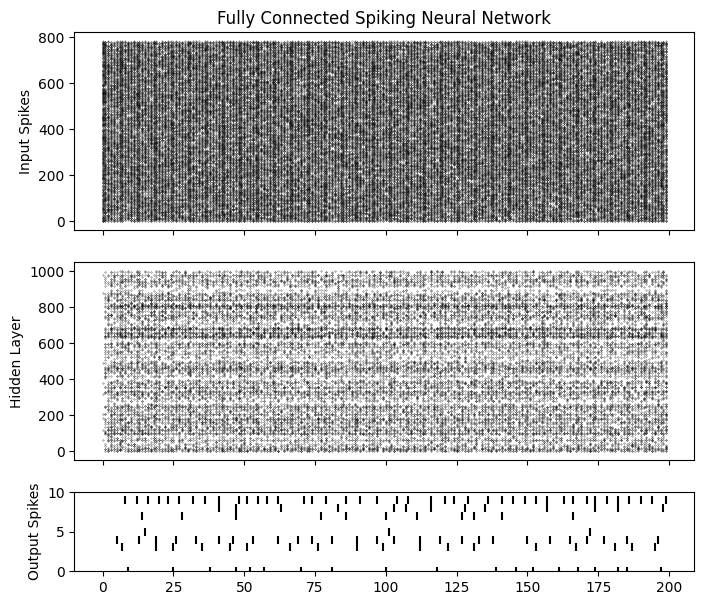

In [ ]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes  should appear to be propagating from the first layer through to the output. If you are not seeing any spikes, then you might have been unlucky in the weight initialization lottery - you might want to try re-running the last four code-blocks.

`spikeplot.spike_count` can create a spike counter of the output layer. The following animation will take some time to generate. <br>

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe

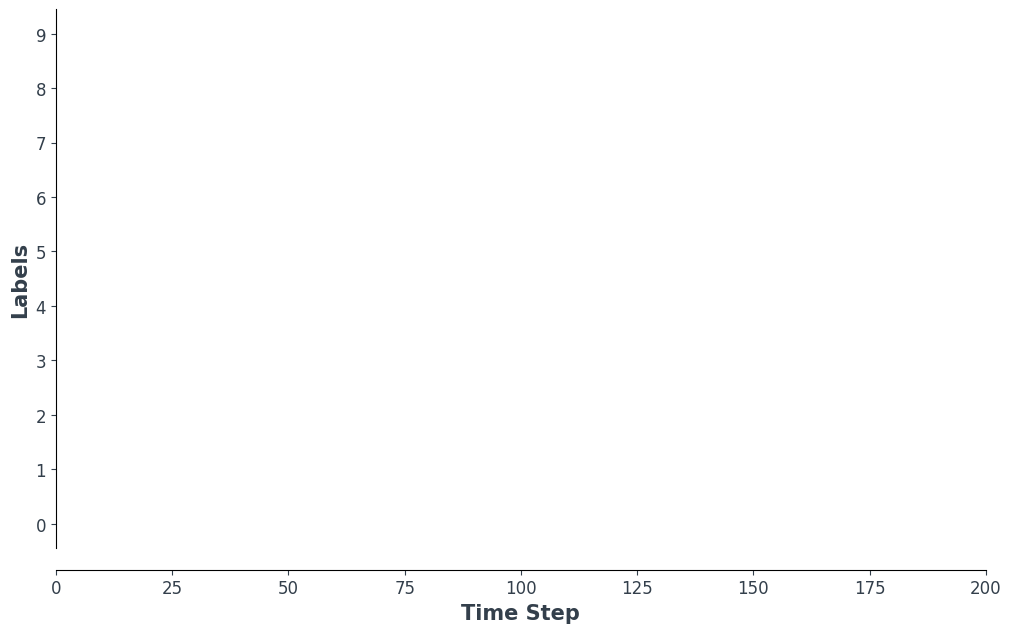

In [ ]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons.
Compare it to the animation and raster plot above to see if you can match the traces to the neuron.

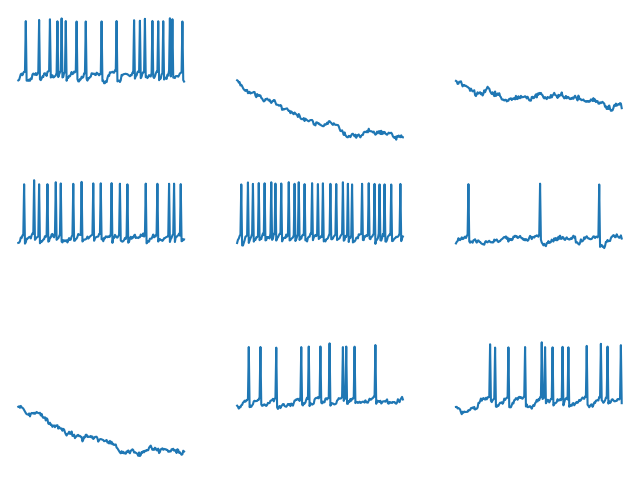

In [ ]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Introduction
In this tutorial, you will:
* Learn how spiking neurons are implemented as a recurrent network
* Understand backpropagation through time, and the associated challenges in SNNs such as the non-differentiability of spikes
* Train a fully-connected network on the static MNIST dataset

<!-- * Implement various backprop strategies:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

>Part of this tutorial was inspired by Friedemann Zenke's extensive work on SNNs. Check out his repo on surrogate gradients [here](https://github.com/fzenke/spytorch), and a favourite paper of mine: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks.](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51–63.

At the end of the tutorial, a basic supervised learning algorithm will be implemented. We will use the original static MNIST dataset and train a multi-layer fully-connected spiking neural network using gradient descent to perform image classification.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In Tutorial 3, we derived a recursive representation of a leaky integrate-and-fire (LIF) neuron:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$

where the input synaptic current is interpreted as $I_{\rm in}[t] = WX[t]$, and $X[t]$ may be some arbitrary input of spikes, a step/time-varying voltage, or unweighted step/time-varying current. Spiking is represented with the following equation, where if the membrane potential exceeds the threshold, a spike is emitted:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

This formulation of a spiking neuron in a discrete, recursive form is almost perfectly poised to take advantage of the developments in training recurrent neural networks (RNNs) and sequence-based models. This is illustrated using an *implicit* recurrent connection for the decay of the membrane potential, and is distinguished from *explicit* recurrence where the output spike $S_{\rm out}$ is fed back to the input. In the figure below, the connection weighted by $-U_{\rm thr}$ represents the reset mechanism $R[t]$.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

The benefit of an unrolled graph is that it provides an explicit description of how computations are performed. The process of unfolding illustrates the flow of information forward in time (from left to right) to compute outputs and losses, and backward in time to compute gradients. The more time steps that are simulated, the deeper the graph becomes.

Conventional RNNs treat $\beta$ as a learnable parameter. This is also possible for SNNs, though by default, they are treated as hyperparameters. This replaces the vanishing and exploding gradient problems with a hyperparameter search. A future tutorial will describe how to make $\beta$ a learnable parameter.

# 2. The Non-Differentiability of Spikes
## 2.1 Training Using the Backprop Algorithm

An alternative way to represent the relationship between $S$ and $U$ in $(2)$ is:

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$

where $\Theta(\cdot)$ is the Heaviside step function:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

Training a network in this form poses some serious challenges. Consider a single, isolated time step of the computational graph from the previous figure titled *"Recurrent representation of spiking neurons"*, as shown in the *forward pass* below:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

The goal is to train the network using the gradient of the loss with respect to the weights, such that the weights are updated to minimize the loss. The backpropagation algorithm achieves this using the chain rule:

$$\frac{\partial \mathcal{L}}{\partial W} =
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$

From $(1)$, $\partial I/\partial W=X$, and $\partial U/\partial I=1$. While we have not yet defined a loss function, we can assume $\partial \mathcal{L}/\partial S$ has an analytical solution, in a similar form to the cross-entropy or mean-square error loss (more on that shortly).

However, the term that we are going to grapple with is $\partial S/\partial U$. The derivative of the Heaviside step function from $(3)$ is the Dirac Delta function, which evaluates to 0 everywhere, except at the threshold $U_{\rm thr} = \theta$, where it tends to infinity. This means the gradient will almost always be nulled to zero (or saturated if $U$ sits precisely at the threshold), and no learning can take place. This is known as the **dead neuron problem**.

## 2.2 Overcoming the Dead Neuron Problem

The most common way to address the dead neuron problem is to keep the Heaviside function as it is during the forward pass, but swap the derivative term $\partial S/\partial U$ for something that does not kill the learning process during the backward pass, which will be denoted $\partial \tilde{S}/\partial U$. This might sound odd, but it turns out that neural networks are quite robust to such approximations. This is commonly known as the *surrogate gradient* approach.

A variety of options exist to using surrogate gradients, and we will dive into more detail on these methods in [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). The default method in snnTorch (as of v0.6.0) is to smooth the Heaviside function with the arctangent function. The backward-pass derivative used is:

$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$

where the left arrow denotes substitution.

The same neuron model described in  $(1)-(2)$ (a.k.a., `snn.Leaky` neuron from Tutorial 3) is implemented in PyTorch below. Don't worry if you don't understand this. This will be condensed into one line of code using snnTorch in a moment:

In [ ]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

Note that the reset mechanism is detached from the computational graph, as the surrogate gradient should only be applied to $\partial S/\partial U$, and not $\partial R/\partial U$.

The above neuron is instantiated using:

In [ ]:
lif1 = LeakySurrogate(beta=0.9)

#3. Backprop Through Time
Equation $(4)$ only calculates the gradient for one single time step (referred to as the *immediate influence* in the figure below), but the backpropagation through time (BPTT) algorithm calculates the gradient from the loss to *all* descendants and sums them together.

The weight $W$ is applied at every time step, and so imagine a loss is also calculated at every time step. The influence of the weight on present and historical losses must be summed together to define the global gradient:

$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} =
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$

The point of $(5)$ is to ensure causality: by constraining $s\leq t$, we only account for the contribution of immediate and prior influences of $W$ on the loss. A recurrent system constrains the weight to be shared across all steps: $W[0]=W[1] =~... ~ = W$. Therefore, a change in $W[s]$ will have the same effect on all $W$, which implies that $\partial W[s]/\partial W=1$:

$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$

As an example, isolate the prior influence due to $s = t-1$ *only*; this means the backward pass must track back in time by one step. The influence of $W[t-1]$ on the loss can be written as:

$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} =
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{Eq.~(5)}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$

We have already dealt with all of these terms from $(4)$, except for $\partial U[t]/\partial U[t-1]$. From $(1)$, this temporal derivative term simply evaluates to $\beta$. So if we really wanted to, we now know enough to painstakingly calculate the derivative of every weight at every time step by hand, and it'd look something like this for a single neuron:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

But thankfully, PyTorch's autodiff takes care of that in the background for us.  

*Note: The reset mechanism has been omitted from the above figure. In snnTorch, reset is included in the forward-pass, but detached from the backward pass.*


# 4. Setting up the Loss / Output Decoding
In a conventional, non-spiking neural network, a supervised, multi-class classification problem takes the neuron with the highest activation and treats that as the predicted class.

In a spiking neural net, there are several options to interpreting the output spikes. The most common approaches are:
* **Rate coding:** Take the neuron with the highest firing rate (or spike count) as the predicted class
* **Latency coding:** Take the neuron that fires *first* as the predicted class

This might feel familiar to [Tutorial 1 on neural encoding](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). The difference is that, here, we are interpreting (decoding) the output spikes, rather than encoding/converting raw input data into spikes.

Let's focus on a rate code. When input data is passed to the network, we want the correct neuron class to emit the most spikes over the course of the simulation run. This then corresponds to the highest average firing frequency. One way to achieve this is to increase the membrane potential of the correct class to $U>U_{\rm thr}$, and that of incorrect classes to $U<U_{\rm thr}$. Applying the target to $U$ serves as a proxy for modulating spiking behavior from $S$.

This can be implemented by taking the softmax of the membrane potential for output neurons, where $C$ is the number of output classes:

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$

The cross-entropy between $p_i$ and the target $y_i \in \{0,1\}^C$, which is a one-hot target vector, is obtained using:

$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

The practical effect is that the membrane potential of the correct class is encouraged to increase while those of incorrect classes are reduced. In effect, this means the correct class is encouraged to fire at all time steps, while incorrect classes are suppressed at all steps. This may not be the most efficient implementation of an SNN, but it is among the simplest.

This target is applied at every time step of the simulation, thus also generating a loss at every step. These losses are then summed together at the end of the simulation:

$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

This is just one of many possible ways to apply a loss function to a spiking neural network. A variety of approaches are available to use in snnTorch (in the module `snn.functional`), and will be the subject of a future tutorial.

With all of the background theory having been taken care of, let’s finally dive into
training a fully-connected spiking neural net.

# 5. Setting up the Static MNIST Dataset

In [ ]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2575781.59it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 349593.93it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3237110.05it/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6865055.41it/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



In [ ]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# 7. Training the SNN

## 7.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [ ]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [ ]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [ ]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

In [ ]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 60.646


In [ ]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 14.06%


In [ ]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [ ]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 48.340
Train set accuracy for a single minibatch: 50.78%


In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 52.34
Test Set Loss: 48.74
Train set accuracy for a single minibatch: 54.69%
Test set accuracy for a single minibatch: 44.53%


Epoch 0, Iteration 50
Train Set Loss: 11.95
Test Set Loss: 13.73
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 13.05
Test Set Loss: 12.60
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 150
Train Set Loss: 12.09
Test Set Loss: 14.64
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 200
Train Set Loss: 7.93
Test Set Loss: 9.26
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 250
Train Set Loss: 9.60
Test Set Loss: 5.19
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.97%


Epoch

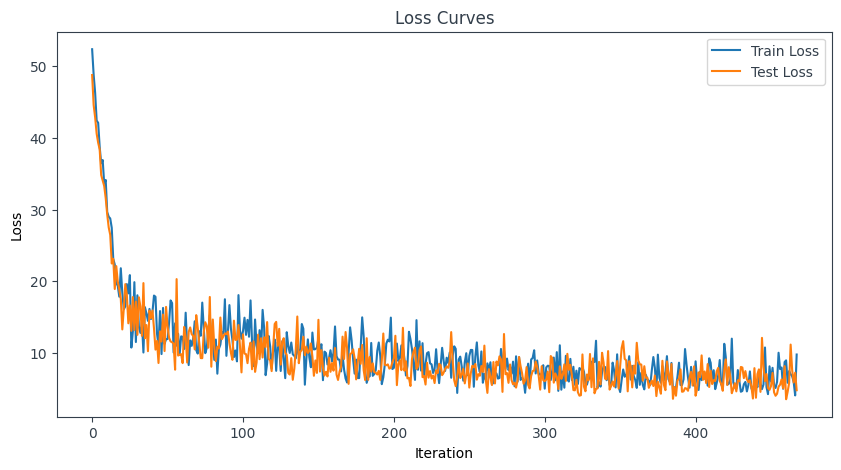

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9306/10000
Test Set Accuracy: 93.06%


In [ ]:
Net().parameters()

<generator object Module.parameters at 0x7af308ee7a70>

In [ ]:
total_params = sum(p.numel() for p in Net().parameters() if p.requires_grad)

In [ ]:
total_params

795010

In [ ]:
 import time

total = 0
correct = 0
predictions = []  # Danh sách để lưu trữ dự đoán
prediction_times = []  # Danh sách để lưu trữ thời gian dự đoán

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        start_time = time.time()  # Bắt đầu thời gian
        test_spk, _ = net(data.view(data.size(0), -1))
        end_time = time.time()  # Kết thúc thời gian

        # Tính thời gian dự đoán cho từng ảnh
        prediction_time = end_time - start_time
        prediction_times.extend([prediction_time] * data.size(0))  # Lưu thời gian cho mỗi ảnh

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        predictions.extend(predicted.cpu().numpy())  # Lưu dự đoán vào danh sách

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# In ra dự đoán và thời gian dự đoán của từng ảnh
for i, (pred, pred_time) in enumerate(zip(predictions, prediction_times)):
    print(f"Image {i}: Predicted class {pred}, Prediction time: {pred_time:.6f} seconds")

Streaming output truncated to the last 5000 lines.
Image 5000: Predicted class 7, Prediction time: 0.167034 seconds
Image 5001: Predicted class 3, Prediction time: 0.167034 seconds
Image 5002: Predicted class 0, Prediction time: 0.167034 seconds
Image 5003: Predicted class 0, Prediction time: 0.167034 seconds
Image 5004: Predicted class 0, Prediction time: 0.167034 seconds
Image 5005: Predicted class 9, Prediction time: 0.167034 seconds
Image 5006: Predicted class 6, Prediction time: 0.167034 seconds
Image 5007: Predicted class 8, Prediction time: 0.167034 seconds
Image 5008: Predicted class 8, Prediction time: 0.167034 seconds
Image 5009: Predicted class 4, Prediction time: 0.167034 seconds
Image 5010: Predicted class 9, Prediction time: 0.167034 seconds
Image 5011: Predicted class 2, Prediction time: 0.167034 seconds
Image 5012: Predicted class 6, Prediction time: 0.167034 seconds
Image 5013: Predicted class 3, Prediction time: 0.167034 seconds
Image 5014: Predicted class 4, Predicti